In [ ]:
!pip install pandas


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 3.8 MB/s eta 0:00:00a 0:00:01


In [ ]:
from torch.utils.data import Dataset
from PIL import Image
import pandas as pd
import os

class EmotionDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.labels_df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.labels_df.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')  # Convert to 3-channel RGB
        label = int(self.labels_df.iloc[idx, 1])

        if self.transform:
            image = self.transform(image)

        return image, label


In [ ]:
import torchvision.transforms as transforms

# Define transforms (resize, normalize, etc.)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])


In [ ]:
import torch

from torch.utils.data import DataLoader

# Paths
csv_file = './augmented_labels.csv'  # path to your CSV
image_root_dir = './'

# Create dataset
full_dataset = EmotionDataset(csv_file=csv_file, root_dir=image_root_dir, transform=transform)

# (Optional) Split into train and validation sets
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


In [ ]:
!pip install timm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 2.0 MB/s eta 0:00:00a 0:00:01


In [ ]:
# Import required libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import timm
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image
import pandas as pd
import os
import numpy as np

/Users/roy/opt/anaconda3/envs/myenv310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


In [ ]:
# Define a custom Dataset to load images and labels
class EmotionDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.labels_df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

        # Create a label-to-index mapping automatically
        self.label_to_idx = {label: idx for idx, label in enumerate(sorted(self.labels_df.iloc[:,1].unique()))}

        # Replace label names with indices
        self.labels_df.iloc[:,1] = self.labels_df.iloc[:,1].map(self.label_to_idx)

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.labels_df.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        label = int(self.labels_df.iloc[idx, 1])

        if self.transform:
            image = self.transform(image)

        return image, label



In [ ]:
# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])


In [ ]:
# Specify your paths
csv_file = './augmented_labels.csv'       # Path to your label CSV
image_root_dir = './'     # <<< Modify this to your actual image folder

# Create dataset
full_dataset = EmotionDataset(csv_file=csv_file, root_dir=image_root_dir, transform=transform)

# Split into training and validation sets
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

print(f"Training samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}")


Training samples: 120636, Validation samples: 30159


In [ ]:
# Load a pre-trained ViT model
model = timm.create_model('vit_tiny_patch16_224', pretrained=True)

# Modify the final classification head
model.head = nn.Linear(model.head.in_features, len(full_dataset.labels_df.iloc[:,1].unique()))

# Move model to device
model = model.to(device)


In [ ]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [ ]:
import time
from torch.cuda.amp import autocast, GradScaler

# Define number of epochs
num_epochs = 5
print_every_n_batches = 10  # Print every N batches

# Start overall training timer
total_start_time = time.time()

# Initialize scaler for mixed precision
scaler = GradScaler()

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    epoch_start_time = time.time()

    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        # ---- Use autocast for mixed precision ----
        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        # Check if loss is NaN
        if torch.isnan(loss):
            print("Loss is NaN. Stopping training to prevent wasted computation.")
            break

        # ---- Scale loss and backpropagate ----
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        # Print training status every N batches
        if (batch_idx + 1) % print_every_n_batches == 0 or (batch_idx + 1) == len(train_loader):
            print(f"Epoch [{epoch+1}/{num_epochs}] | Batch [{batch_idx+1}/{len(train_loader)}] "
                  f"| Loss: {loss.item():.4f}")

    epoch_end_time = time.time()

    # Calculate epoch stats
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    epoch_time = epoch_end_time - epoch_start_time

    # Print epoch summary
    print(f"--- Epoch [{epoch+1}/{num_epochs}] Completed ---")
    print(f"Loss: {epoch_loss:.4f} | Accuracy: {epoch_acc:.2f}% | Time: {epoch_time:.2f} seconds\n")

# End overall training timer
total_end_time = time.time()
total_training_time = (total_end_time - total_start_time) / 60  # minutes

print(f"Total Training Time: {total_training_time:.2f} minutes")


/Users/roy/opt/anaconda3/envs/myenv310/lib/python3.10/site-packages/torch/cuda/amp/grad_scaler.py:126: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/Users/roy/opt/anaconda3/envs/myenv310/lib/python3.10/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [1/5] | Batch [10/943] | Loss: 1.9068
Epoch [1/5] | Batch [20/943] | Loss: 1.7924
Epoch [1/5] | Batch [30/943] | Loss: 1.6897
Epoch [1/5] | Batch [40/943] | Loss: 1.7346
Epoch [1/5] | Batch [50/943] | Loss: 1.7198
Epoch [1/5] | Batch [60/943] | Loss: 1.6038
Epoch [1/5] | Batch [70/943] | Loss: 1.5915
Epoch [1/5] | Batch [80/943] | Loss: 1.6530
Epoch [1/5] | Batch [90/943] | Loss: 1.6319
Epoch [1/5] | Batch [100/943] | Loss: 1.5425
Epoch [1/5] | Batch [110/943] | Loss: 1.5450
Epoch [1/5] | Batch [120/943] | Loss: 1.5596
Epoch [1/5] | Batch [130/943] | Loss: 1.3060
Epoch [1/5] | Batch [140/943] | Loss: 1.4607
Epoch [1/5] | Batch [150/943] | Loss: 1.4741
Epoch [1/5] | Batch [160/943] | Loss: 1.4424
Epoch [1/5] | Batch [170/943] | Loss: 1.3148
Epoch [1/5] | Batch [180/943] | Loss: 1.4505
Epoch [1/5] | Batch [190/943] | Loss: 1.3982
Epoch [1/5] | Batch [200/943] | Loss: 1.2490
Epoch [1/5] | Batch [210/943] | Loss: 1.3379
Epoch [1/5] | Batch [220/943] | Loss: 1.3293
Epoch [1/5] | Batch

In [ ]:
full_dataset = EmotionDataset(csv_file=csv_file, root_dir=image_root_dir, transform=transform)

# Print Label Mapping
print("Label to Index Mapping:")
for label, idx in full_dataset.label_to_idx.items():
    print(f"{label}: {idx}")


Label to Index Mapping:
angry: 0
disgust: 1
fear: 2
happy: 3
neutral: 4
sad: 5
surprise: 6


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

# Evaluate the model on validation set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = outputs.max(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate overall accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Validation Accuracy: {accuracy*100:.2f}%")

# Calculate macro F1-score
f1 = f1_score(all_labels, all_preds, average='macro')
print(f"Validation Macro F1-Score: {f1:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds))

# Print confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(all_labels, all_preds))


Validation Accuracy: 80.43%
Validation Macro F1-Score: 0.7949

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.80      0.75      4156
           1       0.79      0.84      0.81       430
           2       0.76      0.70      0.73      4067
           3       0.88      0.94      0.91      7761
           4       0.81      0.74      0.77      5655
           5       0.76      0.70      0.72      4659
           6       0.86      0.88      0.87      3431

    accuracy                           0.80     30159
   macro avg       0.79      0.80      0.79     30159
weighted avg       0.80      0.80      0.80     30159


Confusion Matrix:
[[3312   40  189  147  168  228   72]
 [  28  362   11    6    5   13    5]
 [ 391   18 2851  132  235  238  202]
 [  88    6   72 7304  143   73   75]
 [ 352    8  173  398 4177  464   83]
 [ 453   22  355  154  372 3241   62]
 [  69    5   98  136   83   30 3010]]


In [ ]:
pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.


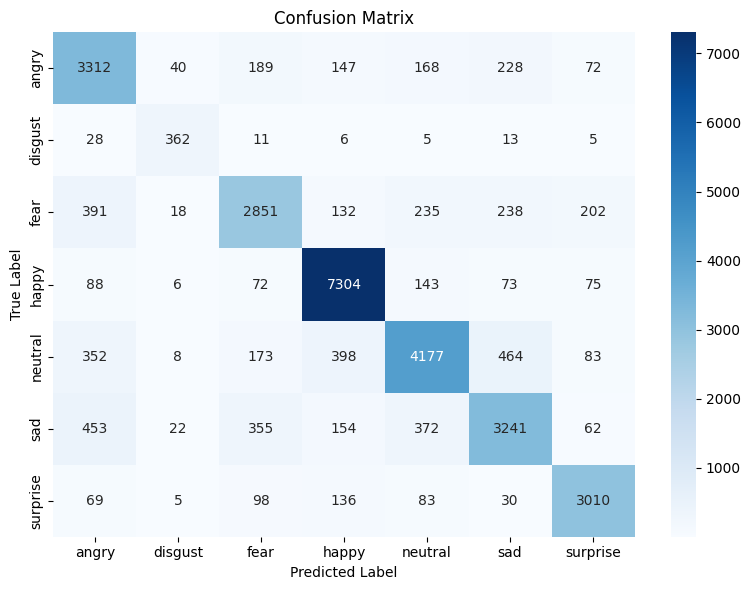

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Optional: Get class names from your dataset
class_names = list(full_dataset.label_to_idx.keys())  # or manually define if needed

# Plot confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()
